# Waves starter code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import xarray as xr

from matplotlib.dates import DateFormatter

Open the netCDF dataset from the CDIP Thredds server. If you are new to Xarray, the function `open_dataset` function uses "lazy loading" meaning we get a peak into the contents of a dataset (as described by its metadata), but the values are not loaded into memory. See: https://docs.xarray.dev/en/latest/internals/internal-design.html.

**Note:** You are not required to used CDIP station 179 (we encourage you to find a station that interests you).  To obtain the OPENDAP access link, click the "THREDDS server" button at the bottom of a CDIP station page, follow the link next to "OPENDAP" under "Access", and then copy the Data URL. Opening the "HTTPServer" will download the .nc file directly.  If you do this, just replace `CDIP_STATION_179_OPENDAP` with the appropriate file path to use this code.


In [2]:
# OPENDAP URL. Replacing `xy` with `rt`provides access to the real time wave data.
CDIP_STATION_179_OPENDAP = 'https://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/179p1_xy.nc'
cdip_all_data = xr.open_dataset(CDIP_STATION_179_OPENDAP)

cdip_all_data

<xarray.Dataset>
Dimensions:              (sourceCount: 100000, xyzCount: 8071082)
Coordinates:
    metaDeployLatitude   float32 ...
    metaDeployLongitude  float32 ...
Dimensions without coordinates: sourceCount, xyzCount
Data variables: (12/16)
    sourceFilename       (sourceCount) object ...
    xyzStartTime         datetime64[ns] ...
    xyzSampleRate        float32 ...
    xyzFilterDelay       float32 ...
    xyzFlagPrimary       (xyzCount) float32 ...
    xyzFlagSecondary     (xyzCount) float32 ...
    ...                   ...
    metaStationName      |S64 ...
    metaPlatform         |S64 ...
    metaInstrumentation  |S64 ...
    metaWaterDepth       float32 ...
    metaDeclination      float32 ...
    metaGridMapping      |S64 ...
Attributes: (12/70)
    naming_authority:                 edu.ucsd.cdip
    keywords_vocabulary:              Global Change Master Directory (GCMD) E...
    date_created:                     2024-05-17T18:03:40Z
    date_issued:                      2024-05-17T18:03:40Z
    date_modified:                    2024-05-17T18:03:40Z
    creator_name:                     Coastal Data Information Program, SIO/UCSD
    ...                               ...
    platform_vocabulary:              http://mmisw.org/ont/ioos/platform
    platform_name:                    ASTORIA CANYON, OR BUOY - 179p1
    DODS.strlen:                      0
    DODS.dimName:                     metaStationNameLength
    DODS_EXTRA.Unlimited_Dimension:   xyzCount
    EXTRA_DIMENSION.metaBoundsCount:  2

(Notice that there is no preview of the actual values for any of the variables. This indicates the data has not yet been loaded.)

To reduce memory usage, we can extract a subset of the dataset prior to loading it into memory.  In this case, we will use a 30-minute data record.

First, reconstruct the time array from the existing `xyzCount` dimension.  From the dataset comments: "UTC measurement times calculated as xyzStartTime + arrayIndex/xyzSampleRate - xyzFilterDelay, where arrayIndex is the displacement array index starting from 0."

In [3]:
def construct_cdip_xy_time(cdip_ds):
    """ Return the datetime array for a CDIP xyz displacement dataset. """
    start_time = cdip_ds.xyzStartTime.data
    sample_rate = cdip_ds.xyzSampleRate.data
    filter_delay = cdip_ds.xyzFilterDelay.data
    count_array = cdip_ds.xyzCount.data  # array([0, ..., record length])
    seconds_since_start_time = count_array * sample_rate **(-1) - filter_delay
    return start_time + pd.to_timedelta(seconds_since_start_time, unit='s')

The time array can then be used to index the Dataset:

In [4]:
xyz_time = construct_cdip_xy_time(cdip_all_data)

# Add the array as a coord along the xyzCount dimension and assign as an index.
cdip_all_data_indexed = (cdip_all_data
                         .assign_coords(xyzTime = ("xyzCount", xyz_time))
                         .set_xindex("xyzTime"))

cdip_all_data_indexed

<xarray.Dataset>
Dimensions:              (sourceCount: 100000, xyzCount: 8071082)
Coordinates:
    metaDeployLatitude   float32 ...
    metaDeployLongitude  float32 ...
  * xyzTime              (xyzCount) datetime64[ns] 2024-03-05T17:57:46.699996...
Dimensions without coordinates: sourceCount, xyzCount
Data variables: (12/16)
    sourceFilename       (sourceCount) object ...
    xyzStartTime         datetime64[ns] 2024-03-05T18:00:00
    xyzSampleRate        float32 1.28
    xyzFilterDelay       float32 133.3
    xyzFlagPrimary       (xyzCount) float32 ...
    xyzFlagSecondary     (xyzCount) float32 ...
    ...                   ...
    metaStationName      |S64 ...
    metaPlatform         |S64 ...
    metaInstrumentation  |S64 ...
    metaWaterDepth       float32 ...
    metaDeclination      float32 ...
    metaGridMapping      |S64 ...
Attributes: (12/70)
    naming_authority:                 edu.ucsd.cdip
    keywords_vocabulary:              Global Change Master Directory (GCMD) E...
    date_created:                     2024-05-17T18:03:40Z
    date_issued:                      2024-05-17T18:03:40Z
    date_modified:                    2024-05-17T18:03:40Z
    creator_name:                     Coastal Data Information Program, SIO/UCSD
    ...                               ...
    platform_vocabulary:              http://mmisw.org/ont/ioos/platform
    platform_name:                    ASTORIA CANYON, OR BUOY - 179p1
    DODS.strlen:                      0
    DODS.dimName:                     metaStationNameLength
    DODS_EXTRA.Unlimited_Dimension:   xyzCount
    EXTRA_DIMENSION.metaBoundsCount:  2

Slice the Dataset using an (arbitrary) 30-minute time window.

In [5]:
start_time = pd.Timestamp('2024-03-10T00:00:00')  #TODO: may need to update
end_time = start_time + pd.Timedelta('30m')

cdip_subset = cdip_all_data_indexed.sel(xyzTime=slice(start_time, end_time))

cdip_subset

<xarray.Dataset>
Dimensions:              (sourceCount: 100000, xyzCount: 2304)
Coordinates:
    metaDeployLatitude   float32 ...
    metaDeployLongitude  float32 ...
  * xyzTime              (xyzCount) datetime64[ns] 2024-03-10T00:00:00.293746...
Dimensions without coordinates: sourceCount, xyzCount
Data variables: (12/16)
    sourceFilename       (sourceCount) object ...
    xyzStartTime         datetime64[ns] 2024-03-05T18:00:00
    xyzSampleRate        float32 1.28
    xyzFilterDelay       float32 133.3
    xyzFlagPrimary       (xyzCount) float32 ...
    xyzFlagSecondary     (xyzCount) float32 ...
    ...                   ...
    metaStationName      |S64 ...
    metaPlatform         |S64 ...
    metaInstrumentation  |S64 ...
    metaWaterDepth       float32 ...
    metaDeclination      float32 ...
    metaGridMapping      |S64 ...
Attributes: (12/70)
    naming_authority:                 edu.ucsd.cdip
    keywords_vocabulary:              Global Change Master Directory (GCMD) E...
    date_created:                     2024-05-17T18:03:40Z
    date_issued:                      2024-05-17T18:03:40Z
    date_modified:                    2024-05-17T18:03:40Z
    creator_name:                     Coastal Data Information Program, SIO/UCSD
    ...                               ...
    platform_vocabulary:              http://mmisw.org/ont/ioos/platform
    platform_name:                    ASTORIA CANYON, OR BUOY - 179p1
    DODS.strlen:                      0
    DODS.dimName:                     metaStationNameLength
    DODS_EXTRA.Unlimited_Dimension:   xyzCount
    EXTRA_DIMENSION.metaBoundsCount:  2

Plot the x displacement (sea surface north displacement).  You should plot y and z displacement too.

In [6]:
cdip_subset['xyzXDisplacement']

<xarray.DataArray 'xyzXDisplacement' (xyzCount: 2304)>
[2304 values with dtype=float32]
Coordinates:
    metaDeployLatitude   float32 ...
    metaDeployLongitude  float32 ...
  * xyzTime              (xyzCount) datetime64[ns] 2024-03-10T00:00:00.293746...
Dimensions without coordinates: xyzCount
Attributes:
    long_name:            sea surface north displacement
    units:                meter
    grid_mapping:         metaGridMapping
    valid_min:            20.47
    valid_max:            -20.47
    ancillary_variables:  xyzFlagPrimary xyzFlagSecondary
    name:                 x displacement
    comment:              UTC measurement times calculated as xyzStartTime + ...

Text(0.5, 0, 'time on 2024-03-10 (UTC)')

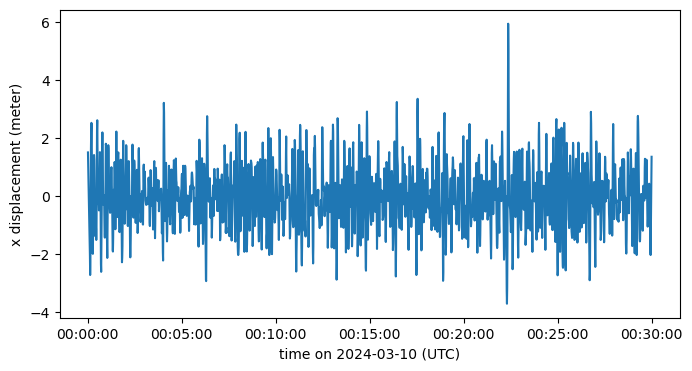

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    cdip_subset['xyzTime'],
    cdip_subset['xyzXDisplacement'],
)

date_format = DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(date_format)

ax.set_ylabel(f"{cdip_subset['xyzXDisplacement'].attrs['name']} "
              f"({cdip_subset['xyzXDisplacement'].attrs['units']})")
ax.set_xlabel(f"time on {cdip_subset['xyzTime'].mean().dt.strftime('%Y-%m-%d').values} (UTC)")

Spectra can be calculated similar to the method used in the ADV starter code.  The spectral density (where density indicates the spectrum is normalized by frequency resolution, $\Delta f$) of displacement in meters will have units of m^2/Hz.

In [8]:
# I suggest you modify these keyword arguments.
pwelch_kwargs = dict(
    window='hann',
    nperseg=None,
    noverlap=None,
    nfft=None,
)

# Compute spectral density of the z displacement.
frequency, spectral_density = scipy.signal.welch(
    x=cdip_subset['xyzZDisplacement'].values,
    fs=cdip_subset['xyzSampleRate'].values,
    scaling='density',
    return_onesided=True,
    axis=-1,
    **pwelch_kwargs,
)